In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances

# === Scientific Reports figure style ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams.update({
    "font.family":     "Helvetica",   # Sci Rep: single sans-serif family
    "font.size":        8,            # 8 pt everywhere after reduction
    "axes.labelsize":   8,
    "axes.titlesize":   8,
    "xtick.labelsize":  8,
    "ytick.labelsize":  8,
    "legend.fontsize":  8,
    "lines.linewidth":  0.6,          # ≥0.5 pt after final sizing
    "figure.dpi":       300,
})
sns.set_theme(context="paper", style="ticks", rc=mpl.rcParams)


In [17]:
# filtered columns for traditional features
trad_feat = pd.read_table('robustness_test/blurred_sigma_0.0_trad_feat.txt')
trad_feat.drop(columns=['image_name'], inplace=True)
print('before filtering:', trad_feat.shape[1])
cols = trad_feat.columns
cellf_cols = [c for c in cols if c.startswith('cellf.')]
nucleusf_cols = [c for c in cols if c.startswith('nucleusf.')]
cols = [c for c in cols if not c.endswith('.cx')]
cols = [c for c in cols if not c.endswith('.cy')]
cols = [c for c in cols if not 'theta' in c]
cols = [c for c in cols if not 'nucleus_cell_dist' in c]
cols = [c for c in cols if not 'cell_nucleus_ratio' in c]
cols = [c for c in cols if not 'tritc_cy5_ratio' in c]
cols = [c for c in cols if not c.startswith('nucleusf.')] # cellf.dapi
cols = [c for c in cols if not c.startswith('cellf.B')] # dapi
print('after filtering:', len(cols))


before filtering: 883
after filtering: 368


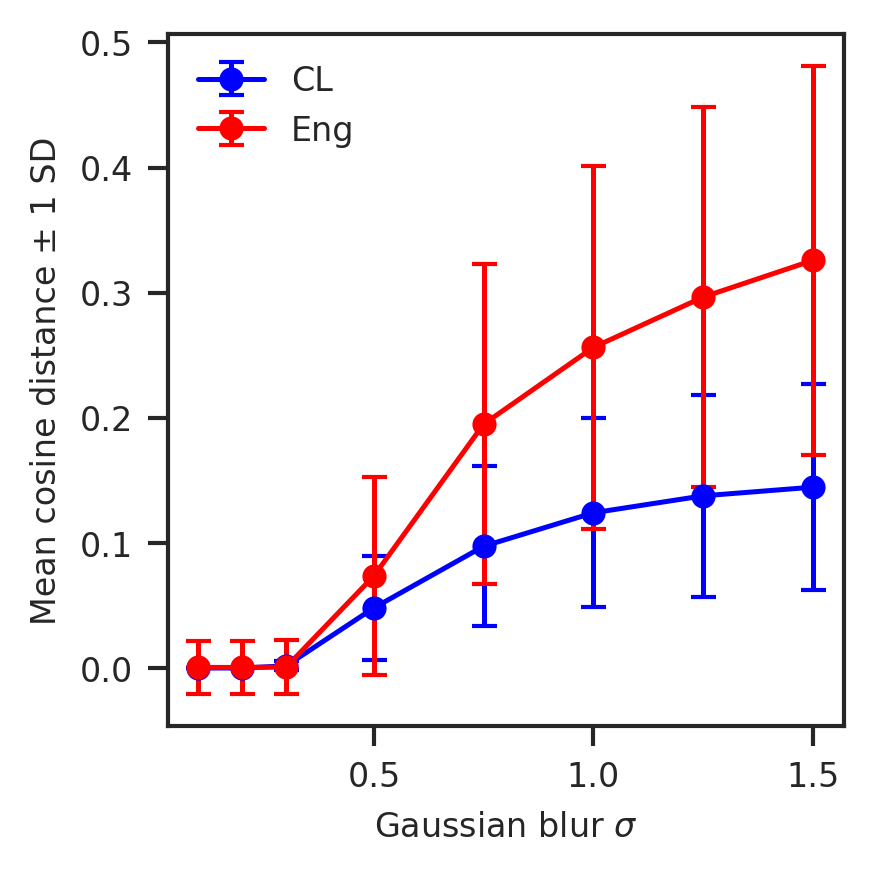

In [19]:

cos_dist_results = {'Sigma': [], 'Feature': [], 'Mean': [], 'Std': []}

sigmas = [0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 1.25, 1.5]

# colour map: CL = blue, Eng = red
colors = {'CL': 'blue', 'Eng': 'red'}

for s in sigmas:
    # --- load once per sigma ---
    emb_orig  = pd.read_table('robustness_test/blurred_sigma_0.0_CL_feat.txt')
    emb_blur  = pd.read_table(f'robustness_test/blurred_sigma_{s}_CL_feat.txt')
    feat_orig = pd.read_table('robustness_test/blurred_sigma_0.0_trad_feat.txt')
    feat_blur = pd.read_table(f'robustness_test/blurred_sigma_{s}_trad_feat.txt')

    # --------- CL features ----------
    dists_cl = np.diagonal(cosine_distances(emb_orig.values,
                                            emb_blur.values))
    cos_dist_results['Sigma'].append(s)
    cos_dist_results['Feature'].append('CL')
    cos_dist_results['Mean'].append(dists_cl.mean())
    cos_dist_results['Std'].append(dists_cl.std(ddof=1))   # sample std

    # --------- traditional features ----------
    dists_trad = np.diagonal(cosine_distances(feat_orig[cols].values,
                                              feat_blur[cols].values))
    cos_dist_results['Sigma'].append(s)
    cos_dist_results['Feature'].append('Eng')
    cos_dist_results['Mean'].append(dists_trad.mean())
    cos_dist_results['Std'].append(dists_trad.std(ddof=1))

cos_dist_results = pd.DataFrame(cos_dist_results)

# ------------------ plot ------------------
fig, ax = plt.subplots(figsize=(3,3))
for feat, grp in cos_dist_results.groupby('Feature'):
    ax.errorbar(grp['Sigma'], grp['Mean'], yerr=grp['Std'],
                marker='o', capsize=3, label=feat,color=colors.get(feat,"grey"))

ax.set_xlabel(r'Gaussian blur $\sigma$', fontsize=8)
ax.set_ylabel('Mean cosine distance ± 1 SD', fontsize=8)
ax.legend(fontsize=8, frameon=False,
          loc='upper left', title_fontsize=8)

#set x ticks size and y ticks size to 8
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.savefig('blur.pdf',
            dpi=600, bbox_inches='tight')
plt.show()


In [20]:
#save the average and std of the cosine distance to a file
cos_dist_results.to_csv('cosine_distance_results.txt', sep='\t', index=False)